<h2><center>ARIMA Forecasting</center></h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas.tseries
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.metrics import mean_squared_error
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
"""function to read the datasets"""
def read_timeseries_csv(file_path, footers, headers):
    df = pd.read_csv(file_path, header = None, names = ['date', 'value'], 
                     parse_dates = ['date'], infer_datetime_format = True,
                     index_col = 'date', skipfooter = footers, skiprows = headers, 
                     engine='python')
    
    """converting values to float"""
    df.value = df.value.astype(str).str.extract('(\d+.\d+)', expand = False).astype(float)
    return df

"""finction to plot Run sequence plots"""
def stationary_check(df, df_name, seasonality):
    plt.figure(figsize = (14, 5))
    plt.plot(df.index, df.value,
             label = 'Actual data', c = 'lightgrey')
    plt.plot(df.index, df.value.rolling(window = seasonality).mean(),
             label = 'Rolling mean ', c = 'red')
    plt.plot(df.index, df.value.rolling(window = seasonality).std(),
             label = 'Rolling std', c = 'green')
    plt.title("Rolling Average and std plot for {} with window {}".format(df_name, seasonality))
    plt.xlabel('date')
    plt.ylabel('value')
    plt.legend()
    plt.show()
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
    plot_pacf(df, ax = axes[0], lags = seasonality)
    axes[0].set_title("pacf " + df_name)
    plot_acf(df, ax = axes[1], lags = 20)
    axes[1].set_title("acf " + df_name)
    

<h4>Read the datasets :</h4>

In [3]:
temp_file_path = 'C:/Users/Kiran/Desktop/S2/DDL_Lab/week5/data/daily-minimum-temperatures-in-me.csv'
passenger_file_path = 'C:/Users/Kiran/Desktop/S2/DDL_Lab/week5/data/AirPassengers.csv'

In [4]:
temp_df = read_timeseries_csv(temp_file_path, 2, 1)
passenger_df = read_timeseries_csv(passenger_file_path, 0, 1)

<h4>Check Correlation with lag :</h4>

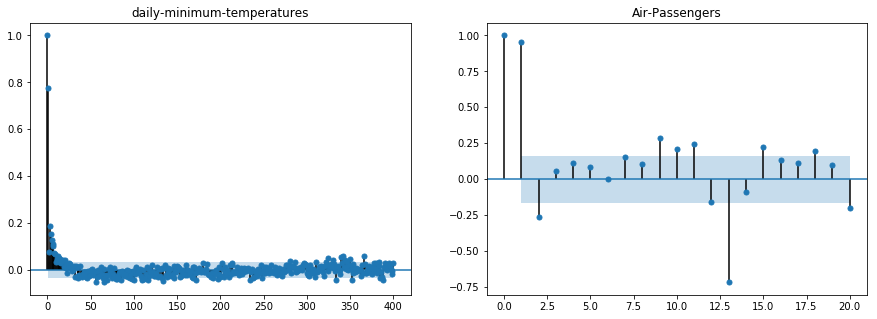

In [5]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
plot_pacf(temp_df, ax = axes[0], lags = 400)
axes[0].set_title('daily-minimum-temperatures')
plot_pacf(passenger_df, ax = axes[1], lags = 20)
axes[1].set_title('Air-Passengers')

<p>The first value is correlated to the 360th value in temprature data and with the 12th data in passenger data</p>

<h2>Check the distribution of data :</h2>

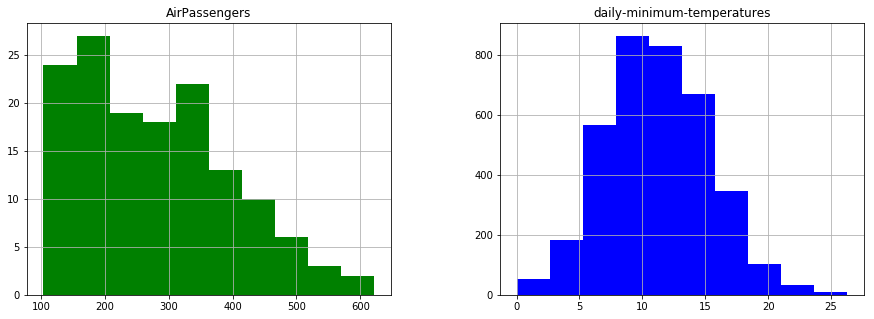

In [6]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
passenger_df.hist(ax = axes[0], color = 'g')
axes[0].set_title('AirPassengers')
temp_df.hist(ax = axes[1], color = 'b')
axes[1].set_title('daily-minimum-temperatures')
plt.show()

<h4>Clearly, the air passengers data cant be assumed as random observations with a mean and std. Therefore we need to convert the data into a gaussian distribution using log transformation.</h4>

<h4>Using log transformation :</h4>

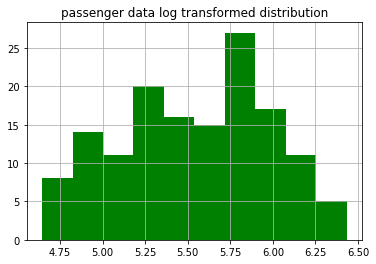

In [7]:
log_pass = np.log(passenger_df)
log_pass.hist(color = 'g')
plt.title("passenger data log transformed distribution")
plt.show()

<h4>Now the log transform of the data can be assumed as a random distribution with mean and standard deviation

<h2>Stationarity Check</h2>

<h3>Stationarity</h3><br><p>A stationary process has the property that the <b>mean, variance and autocorrelation structure</b> do not change over time. For practical purposes, stationarity can usually be determined from a run sequence plot. <b>Run sequence plots</b> are formed by, <br>   Vertical axis: Response variable Yi <br>
Horizontal axis: Index i (i = 1, 2, 3, ... )<br>
<h4>Assumptions of stationary series</h4><br>
<p><b>The mean, variance and autocorrelation structure do not change over time</b></p>
<h4>Transformations to Achieve Stationarity</h4>
<p>1) We can difference the data. That is, given the series Zt, we create the new series
Yi=Zi−Zi−1<br>
2) If the data contain a trend, we can fit some type of curve to the data and then model the residuals from that fit.<br>
3) For non-constant variance, taking the logarithm or square root of the series may stabilize the variance.</p>

<h2>Augmented Dickey-Fuller test :</h2>

 - <b>Null Hypothesis (H0):</b> If accepted, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.<br>
 - <b>Alternate Hypothesis (H1):</b> The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure<br>
 - <b>p-value > 0.05:</b> Accept the null hypothesis (H0), the data has a unit root and is non-stationary.<br>
 - <b>p-value <= 0.05:</b> Reject the null hypothesis (H0), the data does not have a unit root and is stationary.


In [8]:
from statsmodels.tsa.stattools import adfuller

In [9]:
def adf_test(df):
    X = df.values
    X = X.flatten()
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

<h4>Stationarity check daily temprature data :</h4>

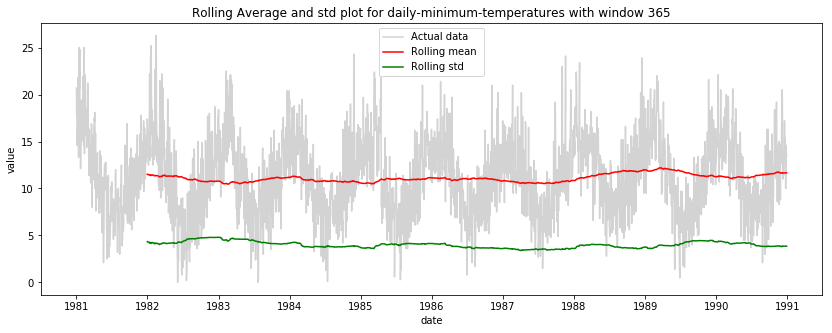

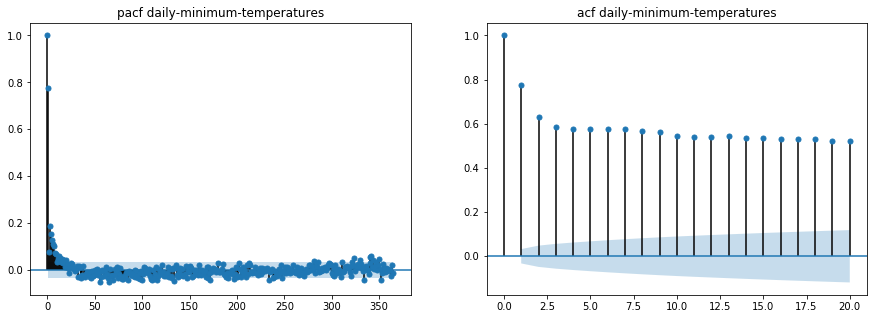

In [10]:
stationary_check(temp_df, "daily-minimum-temperatures", 365)

<h4>As per the assumptions the data is stationary as the mean variance and ACF structure does not change over time. This means the daily air temprature data is stationary. Checking the same using DF test</h4>

In [11]:
adf_test(temp_df)

ADF Statistic: -4.448014
p-value: 0.000244
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


<h4>p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary. Hence the temprature data is by default stationary

<h4>Stationarity check daily temprature data :</h4>

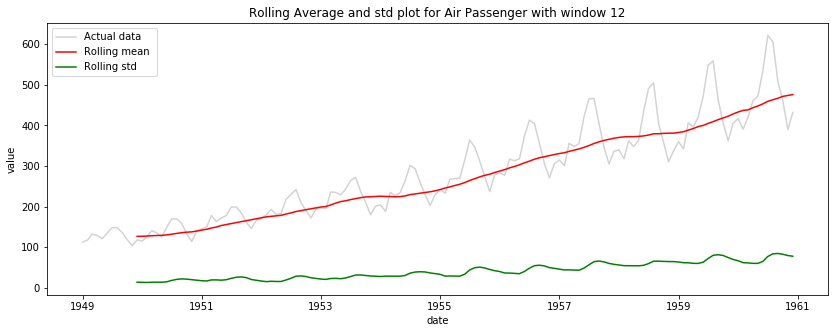

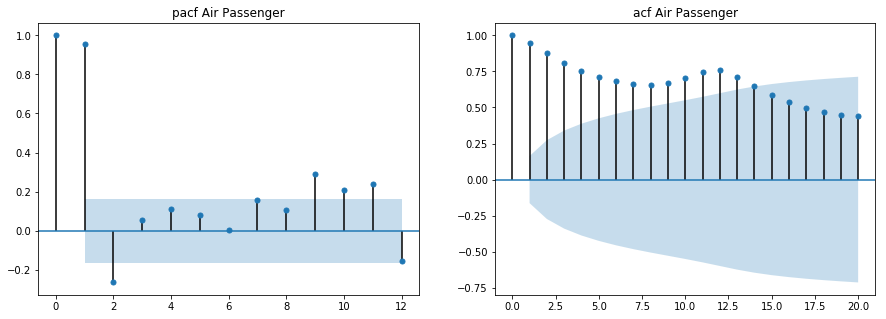

In [12]:
stationary_check(passenger_df, "Air Passenger", 12)

<h4>Based on the graphs there is a clear variation in mean, variance and auto correlation of the air passenger data.

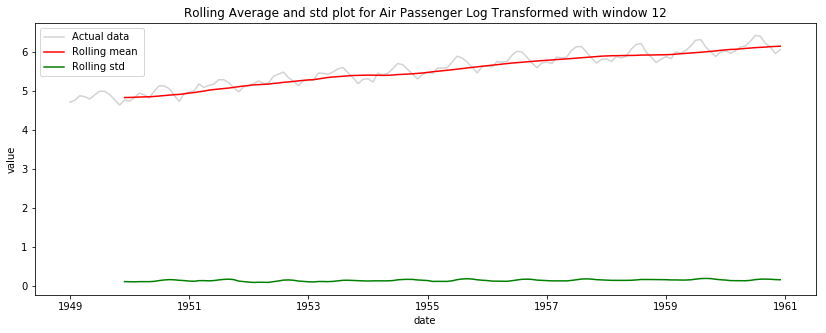

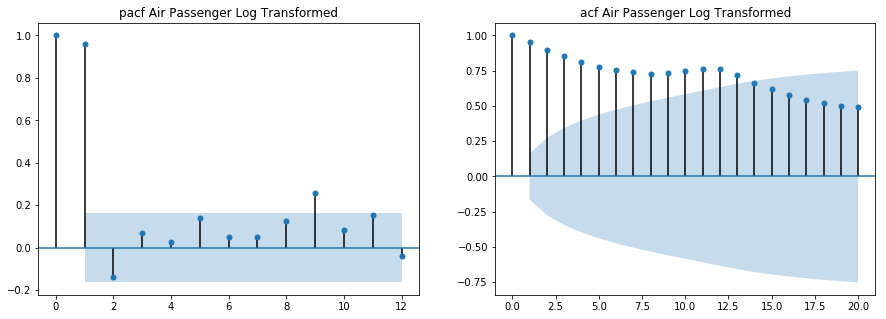

In [13]:
stationary_check(log_pass, "Air Passenger Log Transformed", 12)

<h4>Even after the log transformation, based on the graphs there is a clear variation in mean, variance and auto correlation of the air passenger data.

In [14]:
print("Augmented Dickey-Fuller test for air passenger data")
adf_test(passenger_df)

Augmented Dickey-Fuller test for air passenger data
ADF Statistic: 0.815369
p-value: 0.991880
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


In [15]:
print("Augmented Dickey-Fuller test for air passenger data")
adf_test(log_pass)

Augmented Dickey-Fuller test for air passenger data
ADF Statistic: -1.717017
p-value: 0.422367
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


<h4>As the p value is greater than 0.05 we Accept the null hypothesis (H0), the data has a unit root and is non-stationary

<h3>Making the air passenger data stationary</h3>

<h2>Moving Average :</h2>

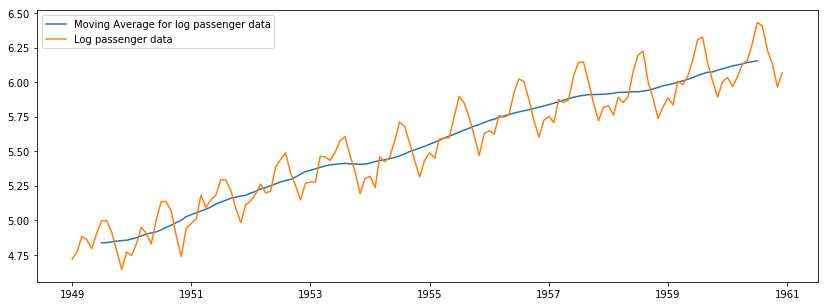

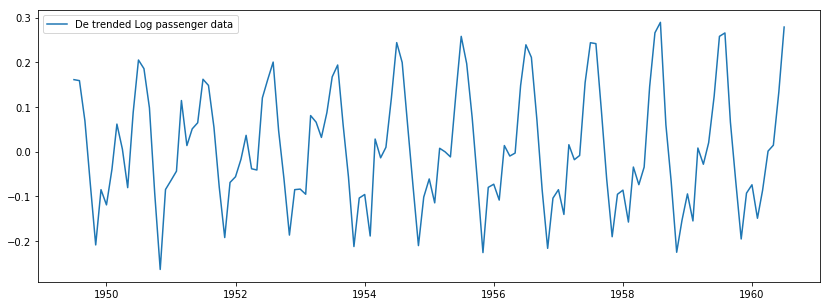

In [16]:
"""using rolling average to make air passengers data smooth"""
moving_avg = log_pass.rolling(window = 12,center = True).mean()
pass_stationary = log_pass - moving_avg
plt.figure(figsize = (14, 5))
plt.plot(moving_avg, label = 'Moving Average for log passenger data')
plt.plot(log_pass, label = 'Log passenger data')
plt.legend()
plt.show()
plt.figure(figsize = (14, 5))
plt.plot(pass_stationary, label = 'De trended Log passenger data')
plt.legend()
plt.show()

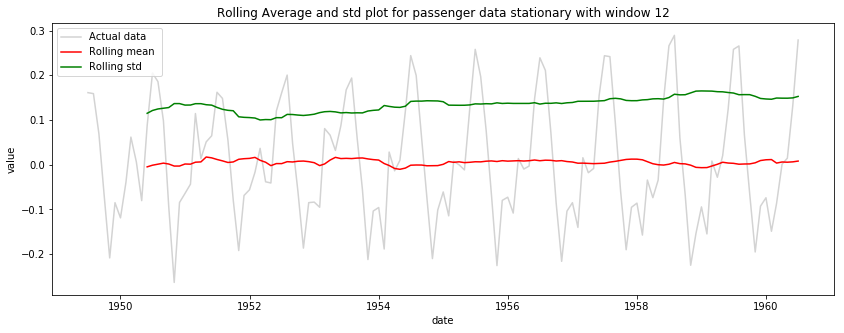

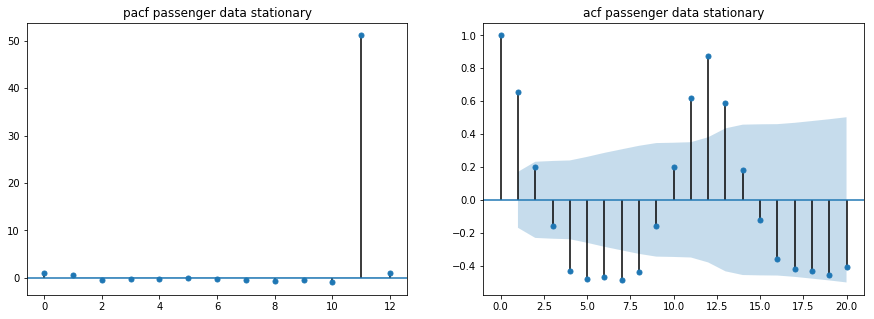

In [17]:
"""using rolling average to make air passengers data smooth"""
pass_stationary.dropna(inplace = True)
stationary_check(pass_stationary, "passenger data stationary", 12)

In [18]:
print("Augmented Dickey-Fuller test for air passenger data")
adf_test(pass_stationary)

Augmented Dickey-Fuller test for air passenger data
ADF Statistic: -4.492454
p-value: 0.000203
Critical Values:
	1%: -3.487
	5%: -2.886
	10%: -2.580


<h4>Since the p value for the de trended data is much less than 0.0002, the data is now stationary.  

<h2>Exponential Moving Average :</h2>

Exponential moving averages takes much faster account of variation in trend. 

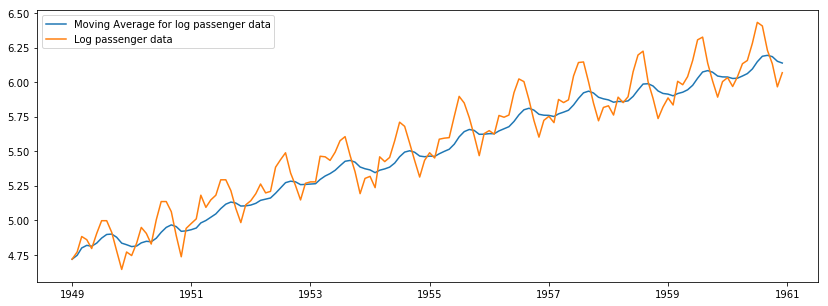

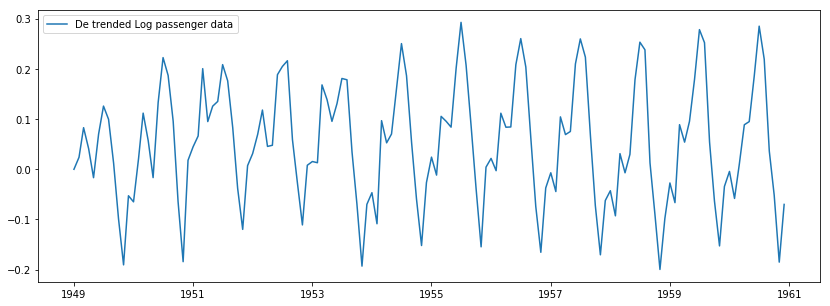

In [19]:
"""using exponential moving average to make air passengers data smooth"""
ema_average = log_pass.ewm(span = 12, adjust = True).mean()
exp_pass_stationary = log_pass - ema_average
plt.figure(figsize = (14, 5))
plt.plot(ema_average, label = 'Moving Average for log passenger data')
plt.plot(log_pass, label = 'Log passenger data')
plt.legend()
plt.show()
plt.figure(figsize = (14, 5))
plt.plot(exp_pass_stationary, label = 'De trended Log passenger data')
plt.legend()
plt.show()

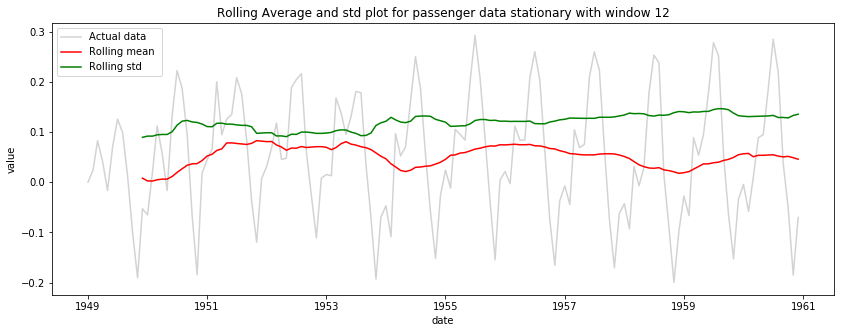

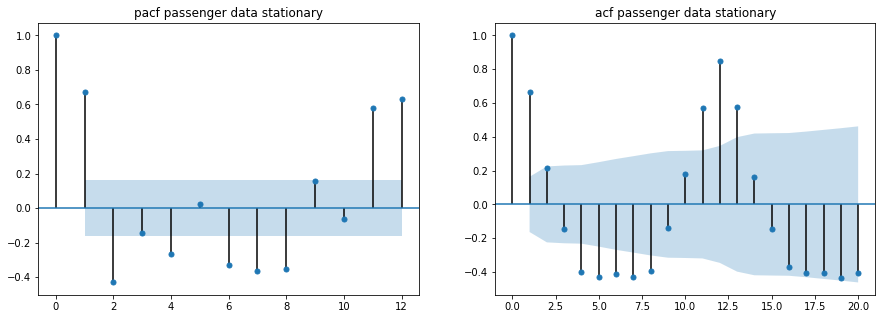

In [20]:
exp_pass_stationary.dropna(inplace=True)
stationary_check(exp_pass_stationary, "passenger data stationary", 12)

In [21]:
print("Augmented Dickey-Fuller test for air passenger data after EWM transformation")
adf_test(exp_pass_stationary)

Augmented Dickey-Fuller test for air passenger data after EWM transformation
ADF Statistic: -3.310542
p-value: 0.014414
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


<h4>The passenger data is stationary as p - value is less than 0.05. 

<h2>2. ARIMA model </h2>

One of the most common methods used in time series forecasting is known as the ARIMA model, which stands for AutoregRessive Integrated Moving Average. ARIMA is a model that can be fitted to time series data in order to better understand or predict future points in the series <br>
There are three distinct integers (p, d, q) that are used to parametrize ARIMA models. Because of that, ARIMA models are denoted with the notation ARIMA(p, d, q). Together these three parameters account for seasonality, trend, and noise in datasets:<br><br>

 - <b>p is the auto-regressive part</b> of the model. It allows us to incorporate the effect of past values into our model. <b>Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.</b><br>
 - <b>d is the integrated part </b>of the model. This includes terms in the model that incorporate the amount of differencing (i.e. the number of past time points to subtract from the current value) to apply to the time series. Intuitively, <b>this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.</b><br>
 - <b>q is the moving average part </b>of the model. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.
<br>
<p>
When dealing with seasonal effects, we make use of the seasonal ARIMA, which is denoted as ARIMA(p,d,q)(P,D,Q)s. Here, (p, d, q) are the non-seasonal parameters described above, while (P, D, Q) follow the same definition but are applied to the seasonal component of the time series. The term s is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.).</p>

<h3> Dataset : AirPassenger</h2>

<h3>Decomposing the data:</h3>

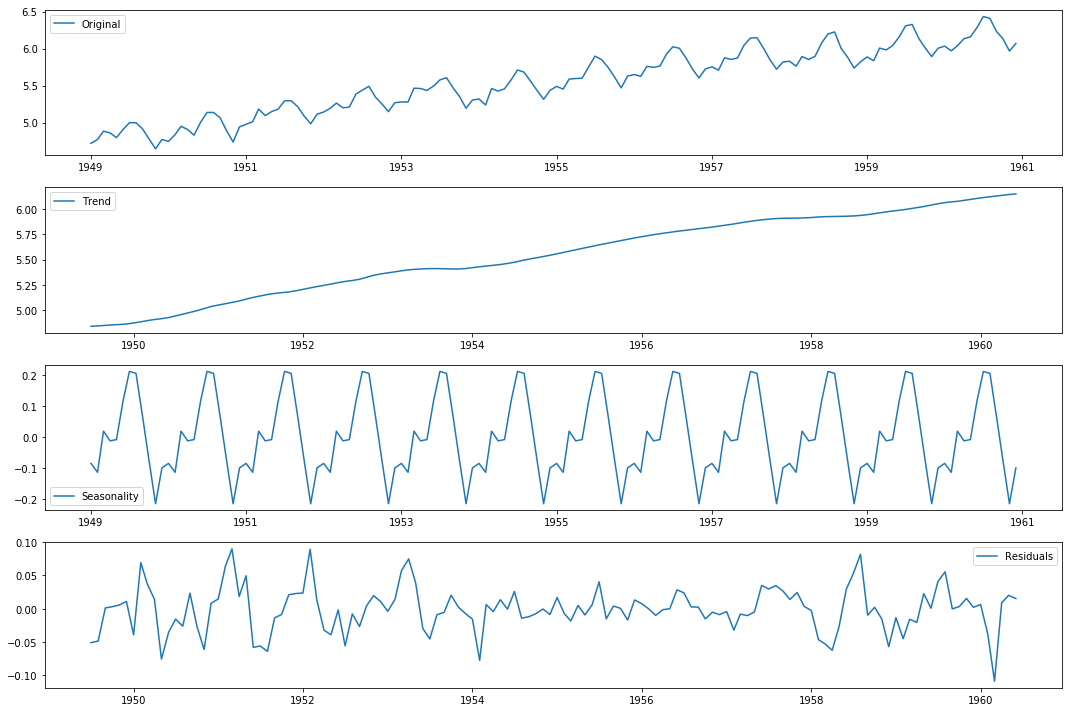

In [22]:
log_pass = np.log(passenger_df)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(log_pass)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, axes = plt.subplots(nrows = 4, ncols = 1, figsize = (15,10))
axes[0].plot(log_pass, label='Original')
axes[0].legend(loc='best')
axes[1].plot(trend, label='Trend')
axes[1].legend(loc='best')
axes[2].plot(seasonal,label='Seasonality')
axes[2].legend(loc='best')
axes[3].plot(residual, label='Residuals')
axes[3].legend(loc='best')
fig.tight_layout()

<h3>Split the data :</h3>

In [69]:
def split_test_validation_test(df):
    last_year = df.index[-1].year
    validation = df[df.index.year == (last_year)]
    train = df[df.index.year < last_year]
    return train, validation

In [74]:
pass_train, pass_validation = split_test_validation_test(np.log(passenger_df))

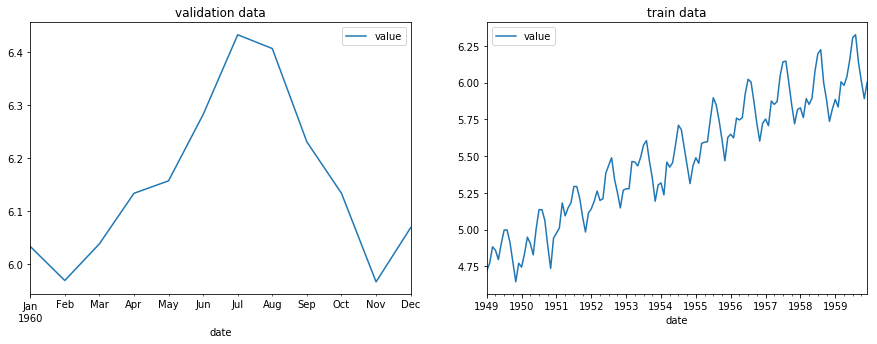

In [75]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
pass_validation.plot(ax = axes[0])
axes[0].set_title("validation data")
pass_train.plot(ax= axes[1])
axes[1].set_title("train data")
plt.show()

In [26]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [27]:

AIC_list = []
param_list = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(pass_train,
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

        results = mod.fit()
        param_list.append((param, param_seasonal))
        AIC_list.append(results.aic)
arg = np.argmin(AIC_list)
print('ARIMA{} with minimum AIC:{}'.format(param_list[arg], AIC_list[arg]))


ARIMA((1, 0, 1), (1, 0, 1, 12)) with minimum AIC:-436.61269029782807


In [28]:
mod = sm.tsa.statespace.SARIMAX(pass_train,
                                order=(1, 0, 1),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9274      0.045     20.550      0.000       0.839       1.016
ma.L1         -0.3160      0.100     -3.148      0.002      -0.513      -0.119
ar.S.L12       1.0216      0.003    324.188      0.000       1.015       1.028
ma.S.L12      -0.5887      0.108     -5.437      0.000      -0.801      -0.376
sigma2         0.0013      0.000      8.414      0.000       0.001       0.002


<b>The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The P>|z| column informs us of the significance of each feature weight. Here, each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.</b>

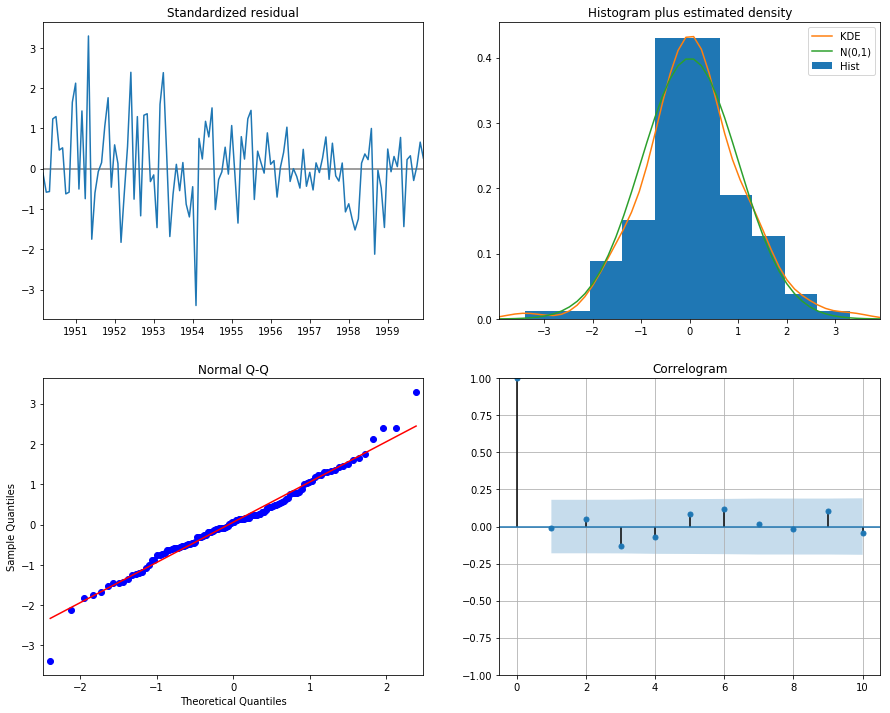

In [29]:
results.plot_diagnostics(figsize=(15, 12))
plt.grid()
plt.show()

 - In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.<br>
 - The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.<br>
 - The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself

In [30]:
pred_uc = results.get_forecast(steps=12)
pred_ci = pred_uc.conf_int()

In [38]:
log_pass = np.log(passenger_df)

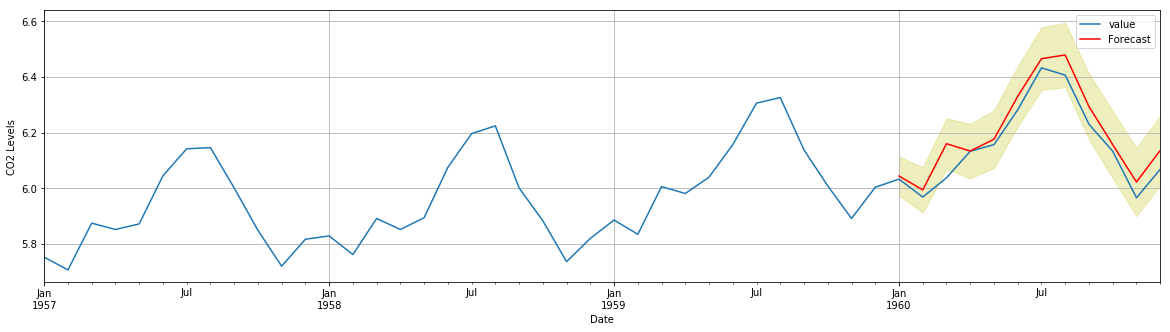

In [39]:
ax = log_pass['1957':].plot(label='observed', figsize=(20, 5))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast', color = "r")
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='y', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.grid()
plt.legend()
plt.show()

In [59]:
pred_uc.predicted_mean

1960-01-01    6.044279
1960-02-01    5.994448
1960-03-01    6.160375
1960-04-01    6.134054
1960-05-01    6.176515
1960-06-01    6.330665
1960-07-01    6.465930
1960-08-01    6.479297
1960-09-01    6.293871
1960-10-01    6.157218
1960-11-01    6.022721
1960-12-01    6.136081
Freq: MS, dtype: float64

In [65]:
prediction = pd.Series(pred_uc.predicted_mean, )
test = pass_validation.iloc[:,0]
test

date
1960-01-01    6.033086
1960-02-01    5.968708
1960-03-01    6.037871
1960-04-01    6.133398
1960-05-01    6.156979
1960-06-01    6.282267
1960-07-01    6.432940
1960-08-01    6.406880
1960-09-01    6.230481
1960-10-01    6.133398
1960-11-01    5.966147
1960-12-01    6.068426
Name: value, dtype: float64

In [67]:
mse = ((prediction - test) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))

The Mean Squared Error of our forecasts is 0.0031


In [76]:
rmse = np.sqrt(((np.exp(prediction) - np.exp(test)) ** 2).mean())
print('The RMSE of our forecasts in actual scale is {}'.format(round(rmse, 4)))

The RMSE of our forecasts in actual scale is 27.4824


<h3>Dataset : Min Temp data </h3>

In [79]:
def plot_train_val(val, train):
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
    val.plot(ax = axes[0])
    axes[0].set_title("validation data")
    train.plot(ax= axes[1])
    axes[1].set_title("train data")
    plt.show()
    
def tune_params(train, span):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], span) for x in list(itertools.product(p, d, q))]
    AIC_list = []
    param_list = []
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False, 
                                            simple_differencing=True)

            results = mod.fit()
            param_list.append((param, param_seasonal))
            AIC_list.append(results.aic)
    return param_list, AIC_list

In [ ]:
train, validation = split_test_validation_test(temp_df)
plot_train_val(validation, train)
span = 365
param_list, AIC_list = tune_params(train, span)
arg = np.argmin(AIC_list)
print('ARIMA{} with minimum AIC:{}'.format(param_list[arg], AIC_list[arg]))
param, param_seasonal = param_list[arg]
mod = sm.tsa.statespace.SARIMAX(pass_train, order = param, seasonal_order = param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

<h4>Because of the large data set tuning SARIMAX using grid search was not a viable option. Hence trying to use another model 

In [84]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

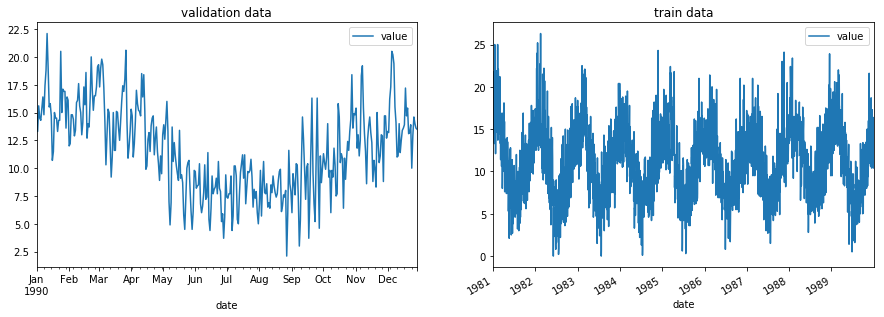

Test RMSE: 2.494


In [100]:
def predict(coef, history):
    yhat = 0.0
    for i in range(1, len(coef)+1):
        yhat += coef[i-1] * history[-i]
    return yhat

train, validation = split_test_validation_test(temp_df)
plot_train_val(validation, train)

train = train.values
test = validation.values
history = [x for x in train]
predictions = []
for t in range(len(test)):
    model = ARIMA(history, order=(1,0,1))
    model_fit = model.fit(trend='nc', disp=False)
    ar_coef, ma_coef = model_fit.arparams, model_fit.maparams
    resid = model_fit.resid
    yhat = predict(ar_coef, history) + predict(ma_coef, resid)
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

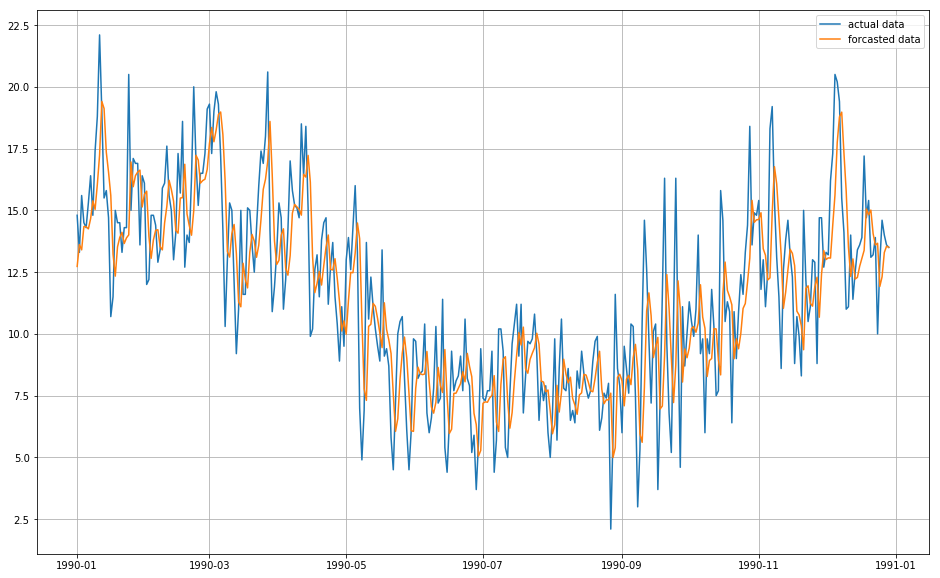

In [107]:
plt.figure(figsize = (16, 10))
plt.plot(validation.index, validation.values, label = "actual data")
plt.plot(validation.index, predictions, label = "forcasted data")
plt.grid()
plt.legend()
plt.show()

<h4>The prediction for the last one year is in line with the actual values and the RMSE for the prediction was 2.5</h4>